<img src="../../code/Resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Training a network to solve the change detection task</h1> 
<h3 align="center">Summer Workshop on the Dynamic Brain</h3> 
<h4 align="center">Day 4 Team</h4> 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b> Exercise 2.4</b> Can you train your own recurrant neural network on the change detection task?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p>To explore this question, let's make some dramatic simplictions.
    <p> * There is a task Oracle which executes the task optimally and it is willing to share its instruction with our naive network (this transforms a temporally sparse credit assignment problem into a 'supervised' one).
    <p> * Our network can be trained in batches (we do not need to execute online or bioplausible learning rules here).
    <p> * Our network does not see images, but instead will see stimulus vectors (here each stimulus represents a different image) which are turned on in a 1-hot manner in flashes. 
    <p> * Our networks output is a single number which we can call the 'licking rate'. The network must learn to supress 'licks' until it sees a change in stimulus. In the way, it must store a working memory against which to compare which stimulus was presented last.
    <p> * Our network can be trained efficiently using Recursive least Squares to map stimulus changes onto internal dynamics and ultimately an output.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> Step 1. Let's define the task structure as a simple sequence of which stimulus is presented at each flash.
    <p> No omissions here, but you are welcome to add them.
</div>

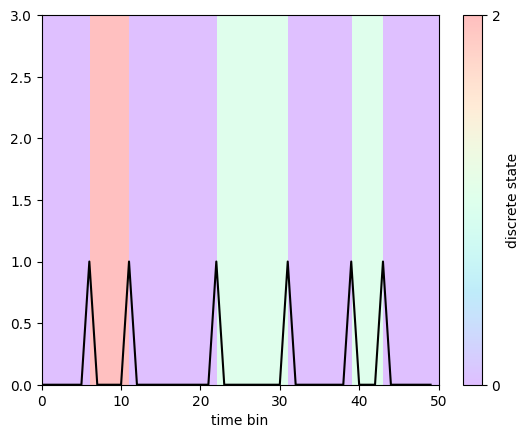

In [1]:
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

num_timebins = 50

initial_distribution = np.array([1/3, 1/3, 1/3])
transition_matrix = np.array([[0.8, 0.1, 0.1], 
                              [0.1,0.8, 0.1],
                              [0.1, 0.1, 0.8]])

# Initialize the outputs
stimuli = np.zeros(num_timebins, dtype=int)
change = np.zeros(num_timebins, dtype=int)

stimuli[0] = npr.choice([0,1,2],p=initial_distribution)      
cts = 0
for t in range(1, num_timebins):
    if cts < 3:
        stimuli[t] = stimuli[t-1]
    else:
        stimuli[t] = npr.choice([0,1,2],p=transition_matrix[stimuli[t-1], :]) 
    if stimuli[t] != stimuli[t-1]:
        cts = 0
        change[t] = 1
    else:
        cts+=1
    
# Plot the simulated data
plt.imshow(stimuli[None, :], cmap="rainbow", alpha=0.25, aspect="auto", 
           extent=(0, num_timebins, 0, 3))
plt.plot(change, 'k')
plt.xlabel("time bin")

cb = plt.colorbar()
cb.set_label("discrete state")
cb.set_ticks([0, 2])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> Step 2. Let's define our Oracle's ideal behavior, but unfolding that sequence across time using the flash timing and when we want the network to 'lick'.
</div>

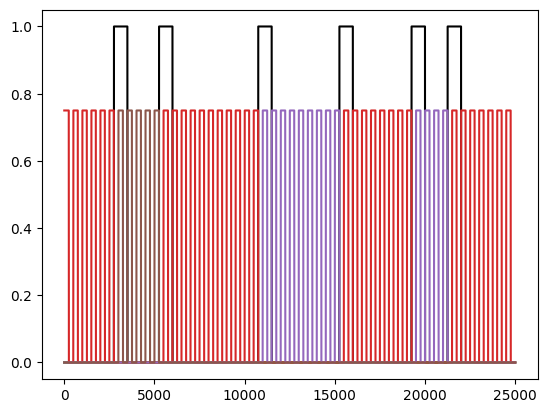

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

def Oracle(dt, showplots=0):
    dt_per_s = round(1/dt)
    numseconds=round(num_timebins/2)
    lengthofgap = round(dt_per_s/4)
    lengthofimage = round(dt_per_s/4)
    lengthoflick = lengthofgap*3

    commandlength = round(0.05*dt_per_s)
    turnlength = round(0.2*dt_per_s)
    t = np.expand_dims(np.linspace(0,numseconds,numseconds*dt_per_s+1),1)
    lick = 0*t
    for i, l in enumerate(change):
        if l == 1:
            lick[i*(lengthofimage + lengthofgap)-lengthofgap:i*(lengthofimage + lengthofgap)-lengthofgap + lengthoflick] = 1
    targ = lick
    
    inp = np.zeros([len(t),3])
    for i, s in enumerate(stimuli):
        inp[i*(lengthofimage + lengthofgap):i*(lengthofimage + lengthofgap)+lengthofimage, s] = 1
    
    hints = np.zeros(inp.shape)

    if showplots == 1:
        plt.figure()
        plt.plot(targ, 'k')
        plt.plot(hints)
        plt.plot(inp*0.75)
        #plt.legend(['Target','Hints','Input'])
        plt.show()
    
    return inp, targ, hints

Oracle(dt=0.001, showplots=1);

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> Step 3: Let's import our favorite training code. Because it is an efficient sequence learner, we will choose to use a FORCE learning based approach which is built around training on target sequences using a Recursive Least Square method on a rank-1 perurbation of a random matrix.
        <p> To add to the efficiency, we will leverage a Full-FORCE which creates neuron-specific targets for improved convergence. 
        <p> Eli Pollack has a nice implementation and transparent version of Full-FORCE which uses numpy and scipy to execute the training (which in turn reduces enviorment dependencies). Let's use that here as the heart of our training.
</div>

In [3]:
'''
FF_Demo: A module file for creating, training, and testing recurrent neural networks using full-FORCE.
Created by Eli Pollock, Jazayeri Lab, MIT 12/13/2017
Modified by MSB adding run methods, multiple inputs, and plotting tools.
'''

import numpy as np
import numpy.random as npr
from scipy import sparse
import matplotlib.pyplot as plt


def create_parameters(dt=0.001):
    '''Use this to define hyperparameters for any RNN instantiation. You can create an "override" script to 
    edit any individual parameters, but simply calling this function suffices. Use the output dictionary to 
    instantiate an RNN class'''
    p = {'network_size': 300,                # Number of units in network
        'dt': dt,                         # Time step for RNN.
        'tau': 0.01,                     # Time constant of neurons
        'noise_std': 0,                    # Amount of noise on RNN neurons
        'g': 1,                         # Gain of the network (scaling for recurrent weights)
        'p': 1,                            # Controls the sparseness of the network. 1=>fully connected.
        'inp_scale': 1,                 # Scales the initialization of input weights
        'out_scale': 1,                 # Scales the initialization of output weights
        'bias_scale': 0,                # Scales the amount of bias on each unit
        'init_act_scale' : 1,            # Scales how activity is initialized
        ##### Training parameters for full-FORCE 
        'ff_steps_per_update': 2 ,    # Average number of steps per weight update
        'ff_alpha': 1,    # "Learning rate" parameter (should be between 1 and 100)
        'ff_num_batches': 10,
        'ff_trials_per_batch': 100,    # Number of inputs/targets to go through
        'ff_init_trials': 3,
        #### Testing parameters
        'test_trials': 10,
        'test_init_trials': 1,
    
    }
    return p

class RNN:
    '''
    Creates an RNN object. Relevant methods:
        __init___:             Creates attributes for hyperparameters, network parameters, and initial activity
        initialize_act:     Resets the activity
        run:                 Runs the network forward given some input
        train:                Uses one of several algorithms to train the network.
    '''

    def __init__(self, hyperparameters, num_inputs, num_outputs):
        '''Initialize the network
        Inputs:
            hyperparameters: should be output of create_parameters function, changed as needed
            num_inputs: number of inputs into the network
            num_outputs: number of outputs the network has
        Outputs:
            self.p: Assigns hyperparameters to an attribute
            self.rnn_par: Creates parameters for network that can be optimized (all weights and node biases)
            self.act: Initializes the activity of the network'''
        self.p = hyperparameters
        rnn_size = self.p['network_size']
        self.rnn_par = {'inp_weights': (npr.rand(num_inputs, rnn_size)-0.5) * 2 * self.p['inp_scale'],
                        'rec_weights': np.array(sparse.random(rnn_size, rnn_size, self.p['p'], 
                                                data_rvs = npr.randn).todense()) * self.p['g']/np.sqrt(rnn_size),
                        'out_weights': (npr.rand(rnn_size, num_outputs)-0.5) * 2 * self.p['out_scale'],
                        'bias': (npr.rand(1,rnn_size)-0.5)*2 * self.p['bias_scale']
                        }
        self.act = npr.randn(1,self.rnn_par['rec_weights'].shape[0])*self.p['init_act_scale']


    def initialize_act(self):
        '''Any time you want to reset the activity of the network to low random values'''
        self.act = npr.randn(1,self.rnn_par['rec_weights'].shape[0])*self.p['init_act_scale']

    def run(self,inputs, record_flag=0):
        '''Use this method to run the RNN on some inputs
        Inputs:
            inputs: An Nxm array, where m is the number of separate inputs and N is the number of time steps
            record_flag: If set to 0, the function only records the output node activity
                If set to 1, if records that and the activity of every hidden node over time
        Outputs:
            output_whole: An Nxk array, where k is the number of separate outputs and N is the number of time steps
            activity_whole: Either an empty array if record_flag=0, or an NxQ array, where Q is the number of hidden units

        '''
        p = self.p
        activity = self.act
        rnn_params = self.rnn_par
        def rnn_update(inp, activity):
            dx = p['dt']/p['tau'] * (-activity + np.dot(np.tanh(activity),rnn_params['rec_weights']) + 
                                        np.dot(inp, rnn_params['inp_weights']) + rnn_params['bias'] + 
                                        npr.randn(1,activity.shape[1]) * p['noise_std'])
            return activity + dx

        def rnn_output(activity):
            return np.dot(np.tanh(activity), rnn_params['out_weights'])

        activity_whole = []
        output_whole = []
        if record_flag==1:    # Record output and activity only if this is active
            activity_whole = np.zeros(((inputs.shape[0]),rnn_params['rec_weights'].shape[0]))
            t=0
         
        for inp in inputs:
            activity = rnn_update(inp, activity)
            output_whole.append(rnn_output(activity))
            if record_flag==1:
                activity_whole[t,:] = activity
                t+=1
        output_whole = np.reshape(output_whole, (inputs.shape[0],-1))
        self.act = activity
        
        return output_whole, activity_whole



    def train(self,inps_and_targs, monitor_training=0, **kwargs):
        '''Use this method to train the RNN using one of several training algorithms!
        Inputs:
            inps_and_targs: This should be a FUNCTION that randomly produces a training input and a target function
                            Those should have individual inputs/targets as columns and be the first two outputs 
                            of this function. Should also take a 'dt' argument.
            monitor_training: Collect useful statistics and show at the end
            **kwargs: use to pass things to the inps_and_targs function
        Outputs:
        Nothing explicitly, but the weights of self.rnn_par are optimized to map the inputs to the targets
        Use this to train the network according to the full-FORCE algorithm, described in DePasquale 2017
        This function uses a recursive least-squares algorithm to optimize the network.
        Note that after each batch, the function shows an example output as well as recurrent unit activity.
        Parameters: 
            In self.p, the parameters starting with ff_ control this function. 

        *****NOTE***** The function inps_and_targs must have a third output of "hints" for training.
        If you don't want to use hints, replace with a vector of zeros (Nx1)

        '''
        # First, initialize some parameters
        p = self.p
        self.initialize_act()
        N = p['network_size']
        self.rnn_par['rec_weights'] = np.zeros((N,N))
        self.rnn_par['out_weights'] = np.zeros((self.rnn_par['out_weights'].shape))


        # Need to initialize a target-generating network, used for computing error:
        # First, take some example inputs, targets, and hints to get the right shape
        try:
            D_inputs, D_targs, D_hints = inps_and_targs(dt=p['dt'], **kwargs)[0:3]
            D_num_inputs = D_inputs.shape[1]
            D_num_targs = D_targs.shape[1]
            D_num_hints = D_hints.shape[1]
            D_num_total_inps = D_num_inputs + D_num_targs + D_num_hints
        except:
            raise ValueError('Check your inps_and_targs function. Must have a hints output as well!')

        # Then instantiate the network and pull out some relevant weights
        DRNN = RNN(hyperparameters = self.p, num_inputs = D_num_total_inps, num_outputs = 1)
        w_targ = np.transpose(DRNN.rnn_par['inp_weights'][D_num_inputs:(D_num_inputs+D_num_targs),:])
        w_hint = np.transpose(DRNN.rnn_par['inp_weights'][(D_num_inputs+D_num_targs):D_num_total_inps,:])
        Jd = np.transpose(DRNN.rnn_par['rec_weights'])

        ################### Monitor training with these variables:
        J_err_ratio = []
        J_err_mag = []
        J_norm = []

        w_err_ratio = []
        w_err_mag = []
        w_norm = []
        ###################

        # Let the networks settle from the initial conditions
        print('Initializing',end="")
        for i in range(p['ff_init_trials']):
            print('.',end="")
            inp, targ, hints = inps_and_targs(dt=p['dt'], **kwargs)[0:3]
            D_total_inp = np.hstack((inp,targ,hints))
            DRNN.run(D_total_inp)
            self.run(inp)
        print('')

        # Now begin training
        print('Training network...')
        # Initialize the inverse correlation matrix
        P = np.eye(N)/p['ff_alpha']
        for batch in range(p['ff_num_batches']):
            print('Batch %g of %g, %g trials: ' % (batch+1, p['ff_num_batches'], p['ff_trials_per_batch']),end="")
            for trial in range(p['ff_trials_per_batch']):
                if np.mod(trial,50)==0:
                    print('')
                print('.',end="")
                # Create input, target, and hints. Combine for the driven network
                inp, targ, hints = inps_and_targs(dt=p['dt'], **kwargs)[0:3]    # Get relevant time series
                D_total_inp = np.hstack((inp,targ,hints))
                # For recording:
                dx = [] # Driven network activity
                x = []    # RNN activity
                z = []    # RNN output
                for t in range(len(inp)):
                    # Run both RNNs forward and get the activity. Record activity for potential plotting
                    dx_t = DRNN.run(D_total_inp[t:(t+1),:], record_flag=1)[1][:,0:5]
                    z_t, x_t = self.run(inp[t:(t+1),:], record_flag=1)

                    dx.append(np.squeeze(np.tanh(dx_t) + np.arange(5)*2))
                    z.append(np.squeeze(z_t))
                    x.append(np.squeeze(np.tanh(x_t[:,0:5]) + np.arange(5)*2))

                    if npr.rand() < (1/p['ff_steps_per_update']):
                        # Extract relevant values
                        r = np.transpose(np.tanh(self.act))
                        rd = np.transpose(np.tanh(DRNN.act))
                        J = np.transpose(self.rnn_par['rec_weights'])
                        w = np.transpose(self.rnn_par['out_weights'])

                        # Now for the RLS algorithm:
                        # Compute errors
                        J_err = (np.dot(J,r) - np.dot(Jd,rd) 
                                -np.dot(w_targ,targ[t:(t+1),:].T) - np.dot(w_hint, hints[t:(t+1),:].T))
                        w_err = np.dot(w,r) - targ[t:(t+1),:].T

                        # Compute the gain (k) and running estimate of the inverse correlation matrix
                        Pr = np.dot(P,r)
                        k = np.transpose(Pr)/(1 + np.dot(np.transpose(r), Pr))
                        P = P - np.dot(Pr,k)

                        # Update weights
                        w = w - np.dot(w_err, k)
                        J = J - np.dot(J_err, k)
                        self.rnn_par['rec_weights'] = np.transpose(J)
                        self.rnn_par['out_weights'] = np.transpose(w)

                        if monitor_training==1:
                            J_err_plus = (np.dot(J,r) - np.dot(Jd,rd) 
                                        -np.dot(w_targ,targ[t:(t+1),:].T) - np.dot(w_hint, hints[t:(t+1),:].T))
                            J_err_ratio = np.hstack((J_err_ratio, np.squeeze(np.mean(J_err_plus/J_err))))
                            J_err_mag = np.hstack((J_err_mag, np.squeeze(np.linalg.norm(J_err))))
                            J_norm = np.hstack((J_norm,np.squeeze(np.linalg.norm(J))))

                            w_err_plus = np.dot(w,r) - targ[t:(t+1),:].T
                            w_err_ratio = np.hstack((w_err_ratio, np.squeeze(w_err_plus/w_err)))
                            w_err_mag = np.hstack((w_err_mag, np.squeeze(np.linalg.norm(w_err))))
                            w_norm = np.hstack((w_norm, np.squeeze(np.linalg.norm(w))))
            ########## Batch callback
            print('') # New line after each batch

            # Convert lists to arrays
            dx = np.array(dx)
            x = np.array(x)
            z = np.array(z)

            if batch==0:
                # Set up plots
                training_fig = plt.figure(figsize=[12,4])
                ax_unit = training_fig.add_subplot(2,1,1)
                ax_out = training_fig.add_subplot(2,1,2)
                tvec = np.arange(0,len(inp))*p['dt']

                # Create output and target lines
                # ******change for multiple inputs
                #lines_targ_out = plt.Line2D(tvec, targ[:,0], linestyle='--',color='r')
                #lines_out = plt.Line2D(tvec, z[:,0], color='b')
                #ax_out.add_line(lines_targ_out)
                #ax_out.add_line(lines_out)
                lines_targ_out = {}
                lines_out = {}
                colorstoplot = ['b', 'g', 'y', 'm', 'o']
                for i in range(D_num_targs):
                    lines_targ_out['%g' % i] = plt.Line2D(tvec, targ[:], linestyle='--', color='r')
                    lines_out['%g' % i]= plt.Line2D(tvec, z[:], color=colorstoplot[i])
                    ax_out.add_line(lines_targ_out['%g' % i])
                    ax_out.add_line(lines_out['%g' % i])

                # Create recurrent unit and DRNN target lines
                lines_targ_unit = {}
                lines_unit = {}
                for i in range(5):
                    lines_targ_unit['%g' % i] = plt.Line2D(tvec, dx[:,i], linestyle='--', color='r')
                    lines_unit['%g' % i]= plt.Line2D(tvec, x[:,i], color='b')
                    ax_unit.add_line(lines_targ_unit['%g' % i])
                    ax_unit.add_line(lines_unit['%g' % i])
                
                # Set up the axes
                ax_out.set_xlim([0,p['dt']*len(inp)])
                ax_unit.set_xlim([0,p['dt']*len(inp)])
                ax_out.set_ylim([-1.2,1.2])
                ax_unit.set_ylim([-2,10])
                ax_out.set_title('Output')
                ax_unit.set_title('Recurrent units, batch %g' % (batch+1))

                # Labels
                ax_out.set_xlabel('Time (s)')
                #ax_out.legend([lines_targ_out,lines_out],['Target','RNN'], loc=1)
            else:
                # Update the plot
                tvec = np.arange(0,len(inp))*p['dt']
                ax_out.set_xlim([0,p['dt']*len(inp)])
                ax_unit.set_xlim([0,p['dt']*len(inp)])
                ax_unit.set_title('Recurrent units, batch %g' % (batch+1))
                for i in range(D_num_targs):
                    lines_targ_out['%g' % i].set_xdata(tvec)
                    lines_targ_out['%g' % i].set_ydata(targ[:])
                    lines_out['%g' % i].set_xdata(tvec)
                    lines_out['%g' % i].set_ydata(z[:])
                for i in range(5):
                    lines_targ_unit['%g' % i].set_xdata(tvec)
                    lines_targ_unit['%g' % i].set_ydata(dx[:,i])
                    lines_unit['%g' % i].set_xdata(tvec)
                    lines_unit['%g' % i].set_ydata(x[:,i])
            training_fig.canvas.draw()
                


        if monitor_training==1:
        # Now for some visualization to see how things went:
            stats_fig = plt.figure(figsize=(8,10))
            plt.subplot(3,2,1)
            plt.title('Recurrent learning error ratio')
            plt.plot(J_err_ratio)

            plt.subplot(3,2,3)
            plt.title('Recurrent error magnitude')
            plt.plot(J_err_mag)        

            plt.subplot(3,2,5)
            plt.title('Recurrent weights norm')
            plt.plot(J_norm)

            plt.subplot(3,2,2)
            plt.plot(w_err_ratio)
            plt.title('Output learning error ratio')

            plt.subplot(3,2,4)
            plt.plot(w_err_mag)
            plt.title('Output error magnitude')

            plt.subplot(3,2,6)
            plt.plot(w_norm)
            plt.title('Output weights norm')
            stats_fig.canvas.draw()

        print('Done training!')

    
    def test(self, inps_and_targs, **kwargs):
        p = self.p
        '''
        Function that tests a trained network. Relevant parameters in p start with 'test'
        Inputs:
            Inps_and_targ: function used to generate time series (same as in train)
            **kwargs: arguments passed to inps_and_targs
        '''

        self.initialize_act()
        print('Initializing',end="")
        for i in range(p['test_init_trials']):
            print('.',end="")
            inp, targ = inps_and_targs(dt=p['dt'], **kwargs)[0:2]
            self.run(inp)
        print('')

        inp, targ = inps_and_targs(dt=p['dt'], **kwargs)[0:2]
        test_fig = plt.figure(figsize=[12,6])
        ax = {}
        line_inp = {}
        line_targ = {}
        line_out = {}
        for zzz in range(targ.shape[1]):
            ax[zzz] = test_fig.add_subplot(targ.shape[1],1,zzz+1)
            tvec = np.arange(0,len(inp))*p['dt']
            ### **trying to fix for multiple inputs
            line_inp[zzz] = plt.Line2D(tvec, inp[:,zzz], linestyle='--', color='g')
            line_targ[zzz] = plt.Line2D(tvec, targ[:,zzz], linestyle='--', color='r')
            line_out[zzz] = plt.Line2D(tvec, targ[:,zzz], color='b')
            ax[zzz].add_line(line_inp[zzz])
            ax[zzz].add_line(line_targ[zzz])
            ax[zzz].add_line(line_out[zzz])
            ax[zzz].legend([line_inp[zzz], line_targ[zzz], line_out[zzz]], ['Input','Target','Output'], loc=1)
            #ax.set_title('RNN Testing: Wait')
            ax[zzz].set_xlim([0,p['dt']*len(inp)])
            ax[zzz].set_ylim([-1.2,1.2])
            ax[zzz].set_xlabel('Time (s)')
        test_fig.canvas.draw()

        E_out = 0 # Running squared error
        V_targ = 0    # Running variance of target
        print('Testing: %g trials' % p['test_trials'])
        for idx in range(p['test_trials']):
            print('.',end="")
            inp, targ = inps_and_targs(dt=p['dt'], **kwargs)[0:2]
            for zzz in range(1): #inp.shape[1]):
                tvec = np.arange(0,len(inp))*p['dt']
                ax[zzz].set_xlim([0,p['dt']*len(inp)])
                line_inp[zzz].set_xdata(tvec)
                line_inp[zzz].set_ydata(inp[:,zzz])
                line_targ[zzz].set_xdata(tvec)
                line_targ[zzz].set_ydata(targ[:,zzz])
                out = self.run(inp)[0]
                line_out[zzz].set_xdata(tvec)
                line_out[zzz].set_ydata(out[:,zzz])
            #ax.set_title('RNN Testing, trial %g' % (idx+1))
            test_fig.canvas.draw()
            
            E_out = E_out + np.dot(np.transpose(out-targ), out-targ)
            V_targ = V_targ + np.dot(np.transpose(targ), targ)
        print('')
        E_norm = E_out/V_targ
        print(E_norm)
        return E_norm


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> Step 4: Let's feed our network of 250 Neurons the Oracle's training sequences.
    <p> Caution, this can be a bit slow, so give yourself some time to let this run for a bit maybe around dinner?
</div>

Initializing...
Training network...
Batch 1 of 10, 10 trials: 
..........
Batch 2 of 10, 10 trials: 
..........
Batch 3 of 10, 10 trials: 
..........
Batch 4 of 10, 10 trials: 
..........
Batch 5 of 10, 10 trials: 
..........
Batch 6 of 10, 10 trials: 
..........
Batch 7 of 10, 10 trials: 
..........
Batch 8 of 10, 10 trials: 
..........
Batch 9 of 10, 10 trials: 
..........
Batch 10 of 10, 10 trials: 
..........
Done training!
Initializing.....
Testing: 10 trials
..........
[[0.28011574]]
CPU times: user 3h 34min 12s, sys: 5h 8min 36s, total: 8h 42min 48s
Wall time: 4h 21min 48s


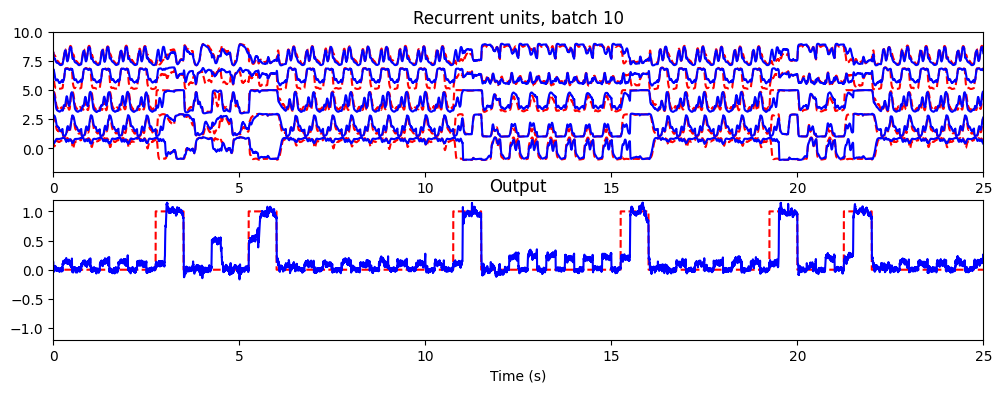

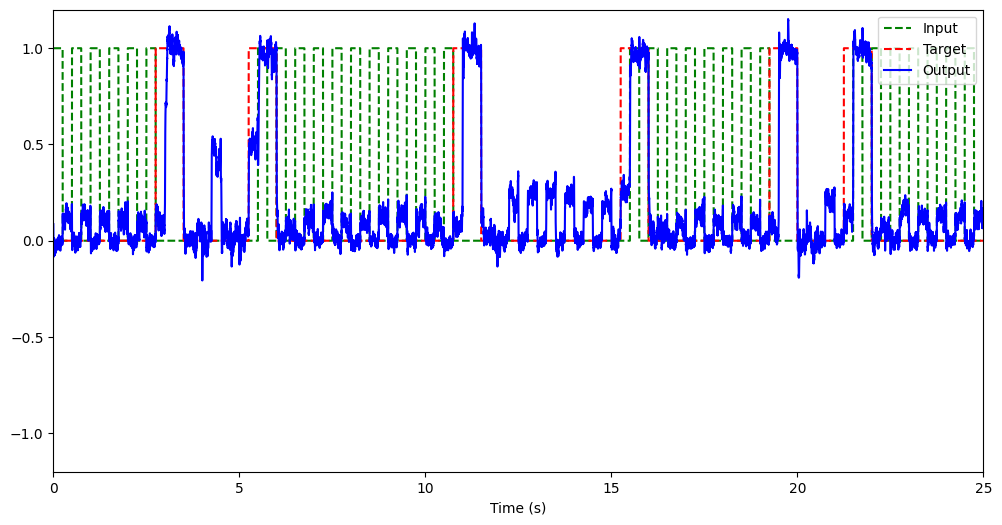

In [4]:
%%time
p = create_parameters(dt=0.001)
p['g'] = 1.5                        # Make sure you understand the importance of this choice
p['ff_num_batches'] = 10
p['ff_trials_per_batch'] = 10
p['test_init_trials']=5
p['init_act_scale'] = 0.1
p['network_size'] = 250            # You will adjust this later on
p['noise_std'] = np.sqrt(2*p['dt'])

number_of_stimuli = 3
number_of_behaviors = 1

rnn = RNN(p,number_of_stimuli, number_of_behaviors)

rnn.train(Oracle, monitor_training=0)

rnn.test(Oracle);

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> While you are waiting, please read up on FORCE learning. 
    <p> https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2756108/
    <p> Are there other training methods you'd like to try?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> <b> Task </b>: Using the rnn.run() method above extract both the outputs (or the 'licking' rate) and the hidden activations (analgous to your neural recordings). 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> <b> Task </b>: Plot up your licking rate and hidden unit activity.
</div>

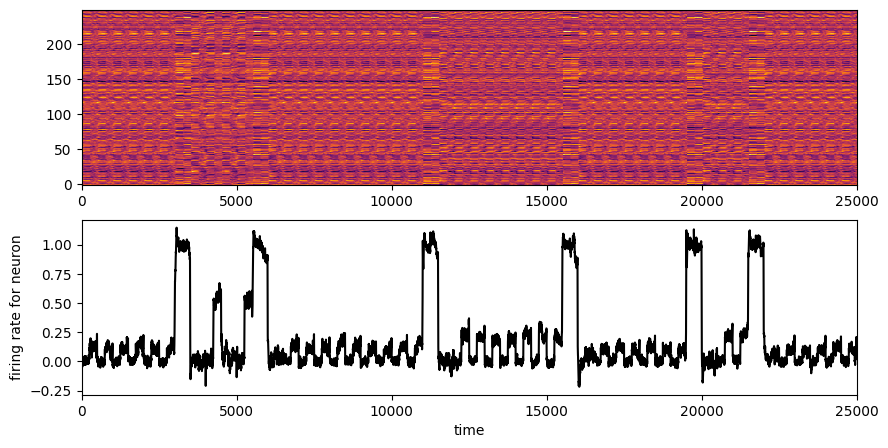

In [5]:
inp,targ,hints = Oracle(dt=0.001, showplots=0)
output, activity = rnn.run(inp, record_flag=1)
fig, ax= plt.subplots(2,1,figsize=[10,5])
ax[0].imshow(activity.T, cmap='inferno', interpolation='nearest', aspect='auto', origin='lower')
plt.xlabel('time')
plt.ylabel('firing rate for neuron')
ax[1].plot(output, 'k')
plt.xlim([0,25000])
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> <b> Task </b>: Save your licking rate and hidden unit activity for later access. Be sure to name the files with the relevant parameters.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> <b> Task </b>: Apply PCA your activity vectors.
</div>

In [6]:
from scipy.ndimage import gaussian_filter1d as gf1d
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
LowDimensionalDynamics = pca.fit_transform(activity)

xg = LowDimensionalDynamics[:,0]
yg = LowDimensionalDynamics[:,1]
zg = LowDimensionalDynamics[:,2]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> <b> Task </b>: Define the stimuluspresented time array such that you know which input block the network was in at each timepoint of the dynamics. 
</div>

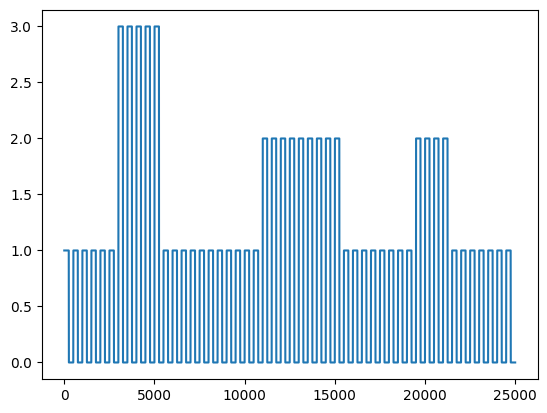

In [7]:
temp = np.hstack( [0.1*np.ones(inp.shape), inp])
stimuluspresented = np.argmax(temp[:,2::], axis=1)
plt.plot(stimuluspresented)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> <b> Task </b>: Plot up your first 3d of reduced dimensional dynamics. 
</div>

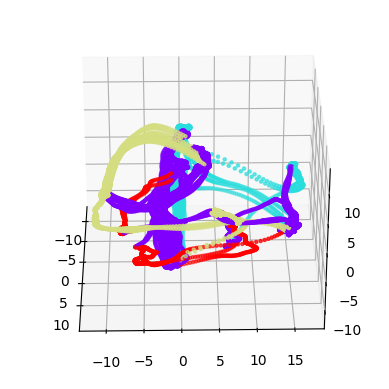

In [8]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# load some test data for demonstration and plot a wireframe
xg = LowDimensionalDynamics[:,0]
yg = LowDimensionalDynamics[:,1]
zg = LowDimensionalDynamics[:,2]
ax.scatter(xg, yg, zg, c= stimuluspresented ,marker='.', cmap='rainbow')

# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> Task: How does your reduced dimensional dynamics reflect the task structure?  
    <p> How is short-term memory encoded? Does the network know which stimulus block it is in?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> <b> Task </b>: Define the hit rate for this network.
    <p> How often would this network enter a catch trial?
    <p> Is there any evidence for behavior states in this simple network? How could you add behavior states if you don't see them now?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> <b> Task </b>: Have fun exploring the implications of network size, the initial std of the RNN's coupling matrix. 
</div>